In [ ]:
!unzip fashion-mnist-master.zip

Archive:  fashion-mnist-master.zip
b2617bb6d3ffa2e429640350f613e3291e10b141
   creating: fashion-mnist-master/
  inflating: fashion-mnist-master/.catwatch.yaml  
 extracting: fashion-mnist-master/.dockerignore  
  inflating: fashion-mnist-master/.gitignore  
  inflating: fashion-mnist-master/.zappr.yaml  
  inflating: fashion-mnist-master/CONTRIBUTING.md  
  inflating: fashion-mnist-master/Dockerfile  
  inflating: fashion-mnist-master/LICENSE  
  inflating: fashion-mnist-master/MAINTAINERS  
  inflating: fashion-mnist-master/README.ja.md  
  inflating: fashion-mnist-master/README.md  
  inflating: fashion-mnist-master/README.zh-CN.md  
  inflating: fashion-mnist-master/app.py  
   creating: fashion-mnist-master/benchmark/
 extracting: fashion-mnist-master/benchmark/__init__.py  
  inflating: fashion-mnist-master/benchmark/baselines.json  
  inflating: fashion-mnist-master/benchmark/convnet.py  
  inflating: fashion-mnist-master/benchmark/runner.py  
  inflating: fashion-mnist-master/c

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Load Fashion-MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_val_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Class names for Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


100%|██████████| 26.4M/26.4M [00:01<00:00, 19.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 470kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.62MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 2.12MB/s]


In [ ]:
from torch.utils.data import random_split

# Normalize pixel values to [0, 1] (already done by ToTensor)
# Split into training, validation, and test sets
val_size = 10000
train_size = len(train_val_set) - val_size
train_set, val_set = random_split(train_val_set, [train_size, val_size])

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

ann_model = ANN()


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

cnn_model = CNN()


In [ ]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                pred = outputs.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()

        val_loss /= len(val_loader.dataset)
        accuracy = 100. * correct / len(val_loader.dataset)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Acc: {accuracy:.2f}%')

    return model


In [ ]:
# Train ANN
print("Training ANN...")
ann_model = train_model(ann_model, train_loader, val_loader)

# Train CNN
print("\nTraining CNN...")
cnn_model = train_model(cnn_model, train_loader, val_loader)

# Evaluate on test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

print("\nEvaluating ANN...")
ann_accuracy = evaluate_model(ann_model, test_loader)
print("\nEvaluating CNN...")
cnn_accuracy = evaluate_model(cnn_model, test_loader)


Training ANN...
Epoch 1, Val Loss: 0.0065, Val Acc: 85.56%
Epoch 2, Val Loss: 0.0060, Val Acc: 86.03%
Epoch 3, Val Loss: 0.0059, Val Acc: 86.12%
Epoch 4, Val Loss: 0.0053, Val Acc: 87.87%
Epoch 5, Val Loss: 0.0052, Val Acc: 88.01%
Epoch 6, Val Loss: 0.0050, Val Acc: 88.65%
Epoch 7, Val Loss: 0.0050, Val Acc: 88.92%
Epoch 8, Val Loss: 0.0049, Val Acc: 89.13%
Epoch 9, Val Loss: 0.0054, Val Acc: 87.77%
Epoch 10, Val Loss: 0.0052, Val Acc: 88.51%

Training CNN...
Epoch 1, Val Loss: 0.0055, Val Acc: 87.30%
Epoch 2, Val Loss: 0.0048, Val Acc: 89.38%
Epoch 3, Val Loss: 0.0043, Val Acc: 90.18%
Epoch 4, Val Loss: 0.0041, Val Acc: 90.54%
Epoch 5, Val Loss: 0.0038, Val Acc: 91.35%
Epoch 6, Val Loss: 0.0036, Val Acc: 91.70%
Epoch 7, Val Loss: 0.0036, Val Acc: 91.67%
Epoch 8, Val Loss: 0.0034, Val Acc: 92.30%
Epoch 9, Val Loss: 0.0035, Val Acc: 92.31%
Epoch 10, Val Loss: 0.0033, Val Acc: 92.63%

Evaluating ANN...
Test Accuracy: 87.76%

Evaluating CNN...
Test Accuracy: 91.97%


Confusion Matrix for ANN:


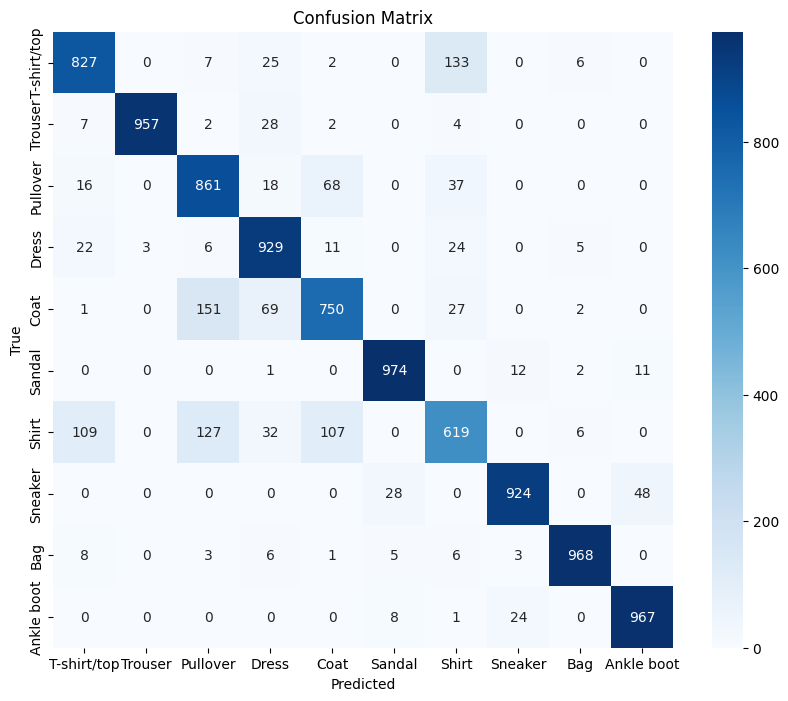


Confusion Matrix for CNN:


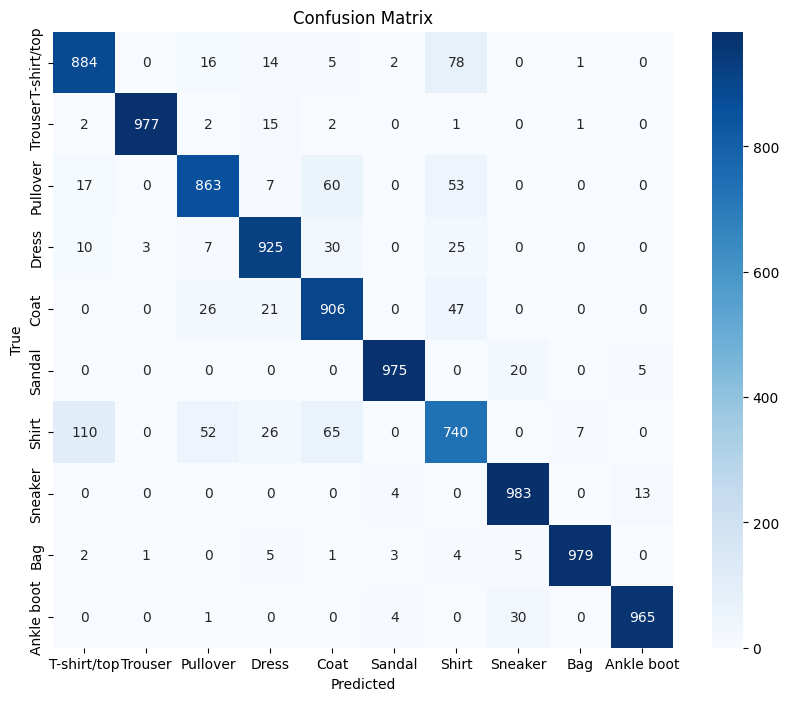

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

print("Confusion Matrix for ANN:")
plot_confusion_matrix(ann_model, test_loader, class_names)
print("\nConfusion Matrix for CNN:")
plot_confusion_matrix(cnn_model, test_loader, class_names)


In [ ]:
#data augmentation and a different optimizer

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import random_split

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),      # Data augmentation
    transforms.ToTensor(),
])

# Load dataset
train_val_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Split into training and validation sets
val_size = 10000
train_size = len(train_val_set) - val_size
train_set, val_set = random_split(train_val_set, [train_size, val_size])

# Data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

ann_model = ANN()


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

cnn_model = CNN()


In [ ]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)  # Using RMSprop

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                pred = outputs.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()

        val_loss /= len(val_loader.dataset)
        accuracy = 100. * correct / len(val_loader.dataset)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Acc: {accuracy:.2f}%')

    return model


In [ ]:
# Train ANN
print("Training ANN...")
ann_model = train_model(ann_model, train_loader, val_loader)

# Train CNN
print("\nTraining CNN...")
cnn_model = train_model(cnn_model, train_loader, val_loader)

# Evaluate on test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

print("\nEvaluating ANN...")
ann_accuracy = evaluate_model(ann_model, test_loader)
print("\nEvaluating CNN...")
cnn_accuracy = evaluate_model(cnn_model, test_loader)


Training ANN...
Epoch 1, Val Loss: 0.0079, Val Acc: 81.62%
Epoch 2, Val Loss: 0.0096, Val Acc: 77.10%
Epoch 3, Val Loss: 0.0094, Val Acc: 78.71%
Epoch 4, Val Loss: 0.0067, Val Acc: 84.13%
Epoch 5, Val Loss: 0.0069, Val Acc: 83.60%
Epoch 6, Val Loss: 0.0067, Val Acc: 84.63%
Epoch 7, Val Loss: 0.0063, Val Acc: 84.54%
Epoch 8, Val Loss: 0.0063, Val Acc: 85.29%
Epoch 9, Val Loss: 0.0062, Val Acc: 85.45%
Epoch 10, Val Loss: 0.0057, Val Acc: 86.89%

Training CNN...
Epoch 1, Val Loss: 0.0070, Val Acc: 83.18%
Epoch 2, Val Loss: 0.0060, Val Acc: 85.62%
Epoch 3, Val Loss: 0.0061, Val Acc: 85.11%
Epoch 4, Val Loss: 0.0056, Val Acc: 86.60%
Epoch 5, Val Loss: 0.0049, Val Acc: 88.48%
Epoch 6, Val Loss: 0.0050, Val Acc: 88.12%
Epoch 7, Val Loss: 0.0049, Val Acc: 88.71%
Epoch 8, Val Loss: 0.0047, Val Acc: 88.86%
Epoch 9, Val Loss: 0.0047, Val Acc: 88.87%
Epoch 10, Val Loss: 0.0046, Val Acc: 89.30%

Evaluating ANN...
Test Accuracy: 87.26%

Evaluating CNN...
Test Accuracy: 90.00%


Confusion Matrix for ANN:


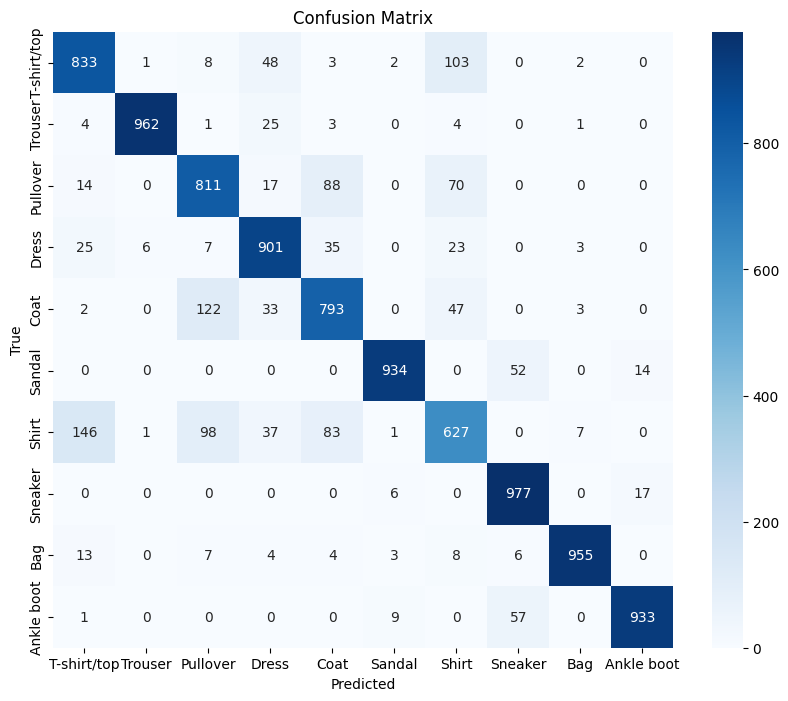


Confusion Matrix for CNN:


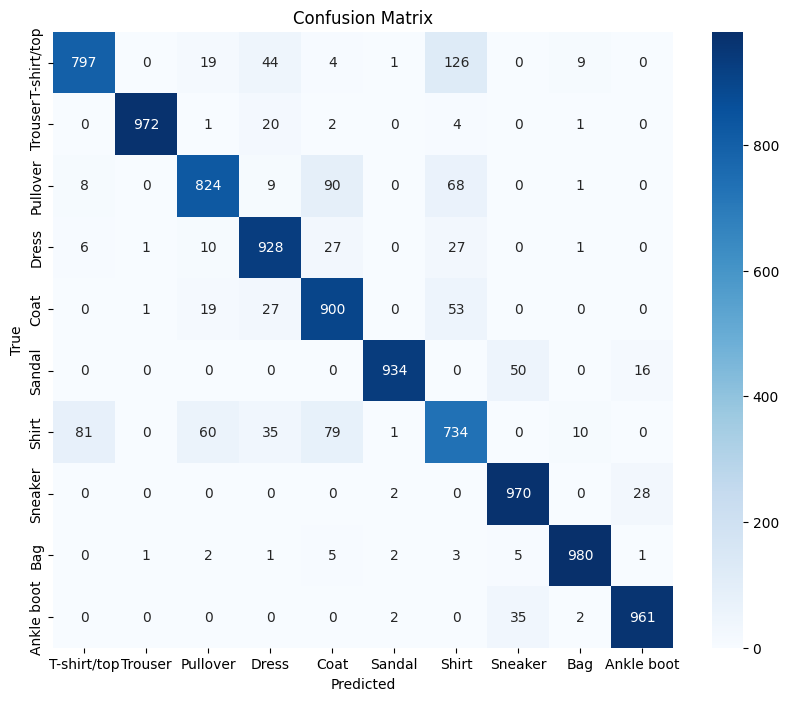

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

print("Confusion Matrix for ANN:")
plot_confusion_matrix(ann_model, test_loader, class_names)
print("\nConfusion Matrix for CNN:")
plot_confusion_matrix(cnn_model, test_loader, class_names)
